# Handle the 'data' of the fishes
Wrestle with our data and Mikkis XLS sheet

In [1]:
import platform
import os
import glob
import pandas
import imageio
import numpy
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import dask
import dask_image.imread
from dask.distributed import Client, LocalCluster
from numcodecs import Blosc
import skimage
from tqdm import notebook

In [2]:
# Set dask temporary folder
# Do this before creating a client: https://stackoverflow.com/a/62804525/323100
import tempfile
if 'Linux' in platform.system():
    tmp = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
elif 'Darwin' in platform.system():
    tmp = tempfile.gettempdir()
else:
    if 'anaklin' in platform.node():
        tmp = os.path.join('F:\\')
    else:
        tmp = os.path.join('D:\\')
dask.config.set({'temporary_directory': os.path.join(tmp, 'tmp')})
print('Dask temporarry files go to %s' % dask.config.get('temporary_directory'))

Dask temporarry files go to D:\tmp


In [3]:
# Start cluster and client now, after setting tempdir
cluster = LocalCluster(n_workers=8)
client = Client(cluster)

In [4]:
print('You can seee what DASK is doing at "http://localhost:%s/status"' % client.scheduler_info()['services']['dashboard'])

You can seee what DASK is doing at "http://localhost:8787/status"


In [5]:
# # Ignore warnings in the notebook
# import warnings
# warnings.filterwarnings("ignore")

In [6]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit
plt.rcParams['figure.dpi'] = 200

In [7]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [8]:
# Display all plots identically
lines = 3
# And then do something like
# plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)

In [9]:
# Different locations if running either on Linux or Windows
FastSSD = False
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
elif 'Darwin' in platform.system():
    FastSSD = False
    BasePath = os.path.join('/Users/habi/Dev/EAWAG/Data')
elif 'Windows' in platform.system():
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('S:\\')
        else:
            BasePath = os.path.join('D:\\Results')
Root = os.path.join(BasePath, 'EAWAG')
print('We are loading all the data from %s' % Root)

We are loading all the data from D:\Results\EAWAG


In [10]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [11]:
def get_projectionsize(logfile):
    """How big did we set the camera?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Number Of Rows' in line:
                y = int(line.split('=')[1])
            if 'Number Of Columns' in line:
                x = int(line.split('=')[1])                
    return(x*y)

In [12]:
def get_filter(logfile):
    """Get the filter we used whole scanning from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Filter=' in line:
                whichfilter = line.split('=')[1].strip()
    return(whichfilter)

In [13]:
def get_exposuretime(logfile):
    """Get the exposure time size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Exposure' in line:
                exposuretime = int(line.split('=')[1])
    return(exposuretime)

In [14]:
def get_ringartefact(logfile):
    """Get the ring artefact correction from the  scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Ring Artifact' in line:
                ringartefactcorrection = int(line.split('=')[1])
    return(ringartefactcorrection)

In [15]:
def get_reconstruction_grayvalue(logfile):
    grayvalue = None
    """How did we map the brightness of the reconstructions?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Maximum for' in line:
                grayvalue = float(line.split('=')[1])
    return(grayvalue)

In [16]:
def get_beamhardening(logfile):
    """Get the beamhardening correction from the  scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Hardening' in line:
                beamhardeningcorrection = int(line.split('=')[1])
    return(beamhardeningcorrection)

In [17]:
def get_rotationstep(logfile):
    """Get the rotation step from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Rotation Step' in line:
                rotstep = float(line.split('=')[1])
    return(rotstep)

In [18]:
def get_frameaveraging(logfile):
    """Get the frame averaging from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Averaging' in line:
                avg = line.split('=')[1]
    return(avg)

In [19]:
def get_machine(logfile):
    """Get the machine we used to scan"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Scanner' in line:
                machine = line.split('=')[1].strip()
    return(machine)

In [20]:
def get_scantime(logfile):
    """How long did we scan?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Scan duration' in line:
                time = line.split('=')[1].strip()
    return(pandas.to_timedelta(time))

In [21]:
def get_stacks(logfile):
    """How many stacks/connected scans did we make?"""
    stacks = 1
    with open(logfile, 'r') as f:
        for line in f:
            if 'conn' in line:
                stacks = int(line.split('=')[1])
    return(stacks)

In [22]:
def get_scandate(logfile, verbose=False):
    """When did we scan the fish?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Study Date and Time' in line:
                if verbose:
                    print('Found "date" line: %s' % line.strip())
                datestring = line.split('=')[1].strip().replace('  ', ' ')
                if verbose:
                    print('The date string is: %s' % datestring)
                date = pandas.to_datetime(datestring , format='%d %b %Y %Hh:%Mm:%Ss')
                if verbose:
                    print('Parsed to: %s' % date)
                (date)
    return(date.isoformat())

In [23]:
def get_git_hash():
    '''
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    '''
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git',
                        '--git-dir',
                        os.path.join(os.getcwd(), '.git'),
                        'rev-parse',
                        '--short',
                        '--verify',
                        'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [24]:
# # Make directory for output
# OutPutDir = os.path.join(os.getcwd(), 'Output', get_git_hash())
# print('We are saving all the output to %s' % OutPutDir)
# os.makedirs(OutPutDir, exist_ok=True)

In [25]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [26]:
# Get *all* log files
# Sort them by time, not name
Data['LogFile'] = [f for f in sorted(glob.glob(os.path.join(Root, '**', '*.log'), recursive=True), key=os.path.getmtime)]

In [27]:
# Get all folders
Data['Folder'] = [os.path.dirname(f) for f in Data['LogFile']]

In [28]:
# Check for samples which are not yet reconstructed
for c, row in Data.iterrows():
    # Iterate over every 'proj' folder
    if 'proj' in row.Folder:
        if not 'TScopy' in row.Folder and not 'PR' in row.Folder:
            # If there's nothing with 'rec*' on the same level, then tell us        
            if not glob.glob(row.Folder.replace('proj', '*rec*')):
                print('- %s is missing matching reconstructions' % row.LogFile[len(Root)+1:])

- 10618\head_proj\10618.log is missing matching reconstructions
- 10618\proj\10618~00.log is missing matching reconstructions
- 10618\proj\10618~01.log is missing matching reconstructions
- 10618\proj\10618~02.log is missing matching reconstructions
- 10618\proj\10618~03.log is missing matching reconstructions


In [29]:
# Get rid of all non-rec logfiles
for c, row in Data.iterrows():
    if 'rec' not in row.Folder:
        Data.drop([c], inplace=True)
    elif 'rectmp.log' in row.LogFile:
        Data.drop([c], inplace=True)
# Reset dataframe to something that we would get if we only would have loaded the 'rec' files
Data = Data.reset_index(drop=True)

In [30]:
# Generate us some meaningful colums
Data['Fish'] = [l[len(Root)+1:].split(os.sep)[0] for l in Data['LogFile']]
Data['Scan'] = [l[len(Root)+1:].split(os.sep)[1] for l in Data['LogFile']]

In [31]:
# Get the file names of the reconstructions
Data['Reconstructions'] = [sorted(glob.glob(os.path.join(f, '*rec0*.png'))) for f in Data['Folder']]
Data['Number of reconstructions'] = [len(r) for r in Data.Reconstructions]

In [32]:
# Drop samples which have not been reconstructed yet
# Based on https://stackoverflow.com/a/13851602
for c,row in Data.iterrows():
    if not row['Number of reconstructions']:
        print('%s contains no PNG files, we might be currently reconstructing it' % row.Folder)
Data = Data[Data['Number of reconstructions'] > 0]
Data.reset_index(drop=True, inplace=True)
print('We have %s folders with reconstructions' % (len(Data)))

D:\Results\EAWAG\103375\rec_stuck contains no PNG files, we might be currently reconstructing it
We have 79 folders with reconstructions


In [33]:
# Get parameters to doublecheck from logfiles
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]
Data['Filter'] = [get_filter(log) for log in Data['LogFile']]
Data['Exposuretime'] = [get_exposuretime(log) for log in Data['LogFile']]
Data['Scanner'] = [get_machine(log) for log in Data['LogFile']]
Data['Averaging'] = [get_frameaveraging(log) for log in Data['LogFile']]
Data['ProjectionSize'] = [get_projectionsize(log) for log in Data['LogFile']]
Data['RotationStep'] = [get_rotationstep(log) for log in Data['LogFile']]
Data['CameraWindow'] = [round((ps ** 0.5)/100)*100  for ps in Data['ProjectionSize']]
Data['Grayvalue'] = [get_reconstruction_grayvalue(log) for log in Data['LogFile']]
Data['RingartefactCorrection'] = [get_ringartefact(log) for log in Data['LogFile']]
Data['BeamHardeningCorrection'] = [get_beamhardening(log) for log in Data['LogFile']]
Data['Scan date'] = [get_scandate(log) for log in Data['LogFile']]
Data['Scan time'] = [get_scantime(log) for log in Data['LogFile']]
Data['Stacks'] = [get_stacks(log) for log in Data['LogFile']]

In [34]:
Data['Scan time total'] = [ st * stk  for st, stk in zip(Data['Scan time'], Data['Stacks'])]

In [35]:
# # https://www.geeksforgeeks.org/iterating-over-rows-and-columns-in-pandas-dataframe/
# columns = list(Data)
# columns.remove('Folder') 
# columns.remove('Fish')
# columns.remove('LogFile')
# columns.remove('Reconstructions')
# columns.remove('Number of reconstructions')
# columns.remove('Grayvalue')
# columns.remove('Scan time')
# columns.remove('Scan time total')
# columns.remove('Scan date')
# print(columns)
# for col in columns:
#     print(col)
#     print(Data[col].unique())
#     print(80*'-')    

In [35]:
# # Check voxel sizes (*rounded* to two after-comma values)
# # If different, spit out which values
# roundto = 2
# if len(Data['Voxelsize'].round(roundto).unique()) > 1:
#     print('We scanned all datasets with %s different voxel sizes' % len(Data['Voxelsize'].round(roundto).unique()))
#     for vs in sorted(Data['Voxelsize'].round(roundto).unique()):
#         print('-', vs, 'um for ', end='')
#         for c, row in Data.iterrows():
#             if float(vs) == round(row['Voxelsize'], roundto):
#                 print(os.path.join(row['Fish'], row['Scan']), end=', ')
#         print('')
# else:
#     print('We scanned all datasets with equal voxel size, namely %s um.' % float(Data['Voxelsize'].round(roundto).unique()))

In [36]:
# if len(Data['Grayvalue'].unique()) > 1:
#     print('We reconstructed the datasets with different maximum gray values, namely')
#     for gv in Data['Grayvalue'].unique():
#         print(gv, 'for Samples ', end='')
#         for c, row in Data.iterrows():
#             if float(gv) == row['Grayvalue']:
#                 print(os.path.join(row['Fish'], row['Scan']), end=', ')
#         print('')
# else:
#     print('We reconstructed all datasets with equal maximum gray value, namely %s.' % Data['Grayvalue'].unique()[0])

In [37]:
# Data[['Fish', 'Scan',
#       'Voxelsize', 'Scanner',
#       'Scan date', 'CameraWindow', 'RotationStep', 'Averaging',
#       'Scan time', 'Stacks', 'Scan time total']]

In [38]:
# Get an overview over the total scan time
# Nice output based on https://stackoverflow.com/a/8907407/323100
total_seconds = int(Data['Scan time total'].sum().total_seconds())
hours, remainder = divmod(total_seconds,60*60)
minutes, seconds = divmod(remainder,60)
print('In total, we scanned for %s hours and %s minutes)' % (hours, minutes))
for machine in Data['Scanner'].unique():
    total_seconds = int(Data[Data['Scanner'] == machine]['Scan time total'].sum().total_seconds())
    hours, remainder = divmod(total_seconds,60*60)
    minutes, seconds = divmod(remainder,60)
    print('\t - Of these, we scanned %s hours and %s minutes on the %s,'
          'for %s scans' % (hours,
                            minutes,
                            machine,
                            len(Data[Data['Scanner'] == machine])))

In total, we scanned for 234 hours and 45 minutes)
	 - Of these, we scanned 102 hours and 26 minutes on the SkyScan1272,for 30 scans
	 - Of these, we scanned 132 hours and 18 minutes on the SkyScan2214,for 49 scans


In [39]:
Data[['Fish', 'Scan',
      'Voxelsize', 'Scanner',
      'Scan date', 'CameraWindow', 'RotationStep', 'Averaging', 'Scan time', 'Stacks' ]].to_excel('Details.xlsx')

In [40]:
Data[['Fish', 'Scan',
      'Voxelsize', 'Scanner',
      'Scan date', 'CameraWindow',
      'RotationStep', 'Averaging', 'Scan time', 'Stacks' ]].to_excel(os.path.join(Root,'Details.xlsx'))

In [42]:
# Read Mikkis datafile
MikkisFile = glob.glob(os.path.join(Root, '*CTscanFishList.xlsx'))[0]
# Read excel file and use the first column as index
print('Reading in %s' % MikkisFile)
DataMikki = pandas.read_excel(MikkisFile)

Reading in D:\Results\EAWAG\02.07.2021_CTscanFishList.xlsx


In [43]:
DataMikki.head()

,Fishec,FieldID,OtherID,ReplacementID,Length(cm),TemporaryJar,Genus,Species,Ecology,Scan date,HeadScan,OralJawScan,PharyngealJawScan,OperculumVisible,DataUploaded,QualityChecked,ScanComments,SpecimenReturned,Comments
0,103635,NaN,NaN,NaN,< 7,< 7cm,"""Astatotilapia""",nubila swamp blue,insectivore,2021-02-08T12:25:19,no 20um headscan,yes,yes,no 20um headscan,NaN,NaN,2-3 inner row of tricuspid teeth,NaN,NaN
1,103635,NaN,NaN,NaN,< 7,< 7cm,"""Astatotilapia""",nubila swamp blue,insectivore,2021-02-08T14:24:12,no 20um headscan,yes,yes,no 20um headscan,NaN,NaN,2-3 inner row of tricuspid teeth,NaN,NaN
2,104016,NaN,NaN,NaN,< 7,< 7cm,Enterochromis I,cinctus (St. E),detritivore,2021-02-04T11:21:23,no,yes,not complete,no,NaN,NaN,pharyngeal jaw not complete,NaN,NaN
3,104016,NaN,NaN,NaN,< 7,< 7cm,Enterochromis I,cinctus (St. E),detritivore,2021-02-04T13:30:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14298,NaN,NaN,NaN,< 7,< 7cm,Incertae sedis,thick skin,insectivore,NaN,no,yes,NaN,no,NaN,NaN,bad segmentation quality,NaN,NaN


In [73]:
# Find the fish we need to scan and display the jar
fish = '1057'
# Did we scan it already?
try:
    print('%s was scanned on %s' % (fish, Data[Data['Fish']==fish]['Scan date'].values[0]))
except IndexError:
    print('Fish %s was not scanned yet' % fish)
# Where is it?    
for d, row in DataMikki.iterrows():
    if (str(fish) in str(row.Fishec)) or (str(fish) in str(row.FieldID)) or (str(fish) in str(row.OtherID)) or str(fish) in str(row.ReplacementID):
        foundfishes = (row.Fishec, row.FieldID, row.OtherID, row.ReplacementID)
        # remove nan from the list of hits
        foundfishes = [x for x in foundfishes if pandas.isnull(x) == False]
        print('An item %s (probably fish %s) is in jar "length=%s cm" (%s))' % (fish,
                                                                                foundfishes,
                                                                                row['Length(cm)'],
                                                                                row['TemporaryJar']))

Fish 1057 was not scanned yet
An item 1057 (probably fish ['10576']) is in jar "length=12 cm" (Mark4))


In [64]:
Data[Data['Fish']==fish]['Scan date'].value

AttributeError: 'Series' object has no attribute 'value'

In [77]:
# # Write scan data to Mikkis file
# # The file from 06.05.21 already contains a 'scan date column', so no need to insert one :)
# # DataMikki['Scan date'] = ''
# # We tried several possibilities with `pandas.merge`, but this was prone to loosing data
# # We thus take the 'dumb' route of looping through all the fishes and writing our info to the desired cell
# for c, row_ours in Data.iterrows():
#     for d, row_mikki in DataMikki.iterrows():
#         if (str(row_ours.Fish) in str(row_mikki.Fishec)) or\
#         (str(row_ours.Fish) in str(row_mikki.FieldID)) or \
#         (str(row_ours.Fish) in str(row_mikki.OtherID)) or \
#         (str(row_ours.Fish) in str(row_mikki.ReplacementID)):
#             DataMikki.at[d, 'Scan date'] = row_ours['Scan date']
# # Write out file as Excel sheet again
# DataMikki.to_excel(MikkisFile)

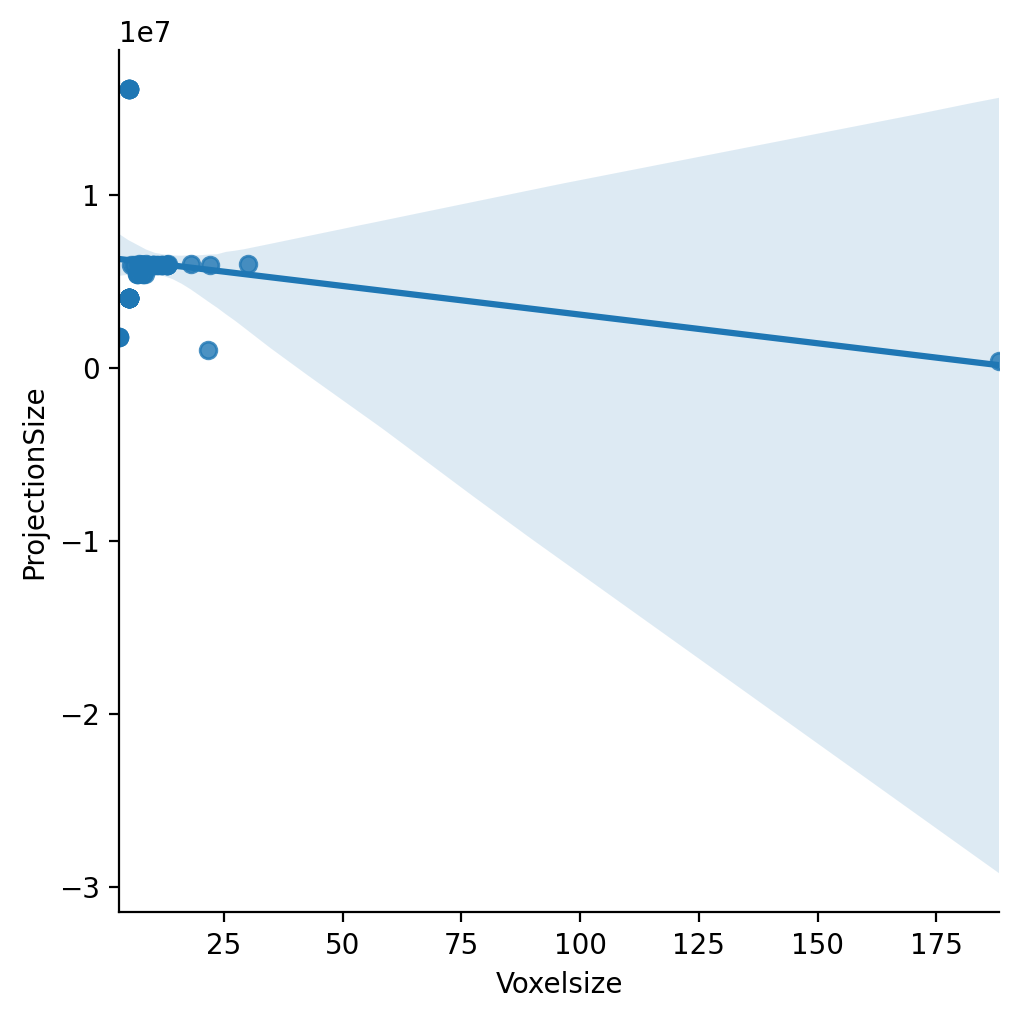

In [47]:
# Convert timedelta to minutes for plotting
# https://stackoverflow.com/a/54729327/323100
# plt.scatter(x=Data['Scan time'].astype('timedelta64[s]') / 3600,
#             y=Data['ProjectionSize']*1e-6)
seaborn.lmplot(data=Data,
               x='Voxelsize',
               y='ProjectionSize'
              )
# plt.ylabel('Projection size [MPx]')
# plt.xlabel('Scan time [h]')
plt.savefig('Scanningtime.png')
plt.show()